### **1 - Import all required libraries**

Allows you to import everything needed for the code that follows.

In [40]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor, LinearRegression, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

### **2 - Prepare X & Y data for training and testing**

We begin by separating the 'target column', which is the outcome we aim to predict with our chosen model. Next, we distinguish between string columns and numeric columns, as they will need to be processed differently. We import the CSV file as a pandas dataframe, create two columns 'month_sin' and 'month_cos' to represent date in a circle, create a route column (route between departure -> arrival), and id_index column based on index from oldest year registered. Then define X, with all its features, and Y, the 'truth' we are trying to determine. Finally, we split the dataset into two parts (80/20), using one part for model training and the other for evaluation.

In [41]:
target_col = 'Retard moyen de tous les trains à l\'arrivée'
categorical_cols = ['Gare de départ', 'Gare d\'arrivée']
numeric_cols = ['Durée moyenne du trajet', 'Is_Service_National', 'Is_Service_International', 'Year', 'month']

df_brut = pd.read_csv('cleaned_dataset.csv')

all_cols = categorical_cols + numeric_cols + [target_col]
df = df_brut.loc[:, all_cols].copy()

df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

numeric_cols.pop()
numeric_cols.extend(['month_sin', 'month_cos'])

df["route"] = df["Gare de départ"] + " -> " + df["Gare d'arrivée"]
categorical_cols.extend(['route'])

df['year_idx'] = df['Year'] - df['Year'].min()
numeric_cols.extend({'year_idx'})
numeric_cols.remove('Year')
year_min = df['Year'].min()

X = df[categorical_cols + numeric_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **3 - Models initialisations (instance & hyperparameters list)**

Now that our training and evaluation data are ready, we create a dictionary to store all our models. For each model, we'll use its name as a key, and its instance and future hyperparameters to be tested as associated values. Hyperparameters are the parameters we define before training the model, and they influence its performance. The goal will then be to determine the most efficient hyperparameters for each model.

In [42]:
models_init = {
    'DummyRegressor': {
        'instance': DummyRegressor(strategy='mean'),
        'param_grid': {
            'model__strategy': ['mean', 'median']
        }
    },
    'LinearRegression': {
        'instance': LinearRegression(),
        'param_grid': {}
    },
    'HuberRegressor': {
        'instance': HuberRegressor(max_iter=1000),
        'param_grid': {
            'model__epsilon': [1.2, 1.35, 1.5, 2.0],
            'model__alpha': [0.0001, 0.001, 0.01, 0.1],
            'model__max_iter': [1000, 2000]
        }
    },
    'Ridge': {
        'instance': Ridge(alpha=1.0),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'instance': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000),
        'param_grid': {
            'model__alpha': [0.001, 0.01, 0.1, 1.0],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'model__max_iter': [5000]
        }
    },
    'DecisionTreeRegressor': {
        'instance': DecisionTreeRegressor(random_state=42, max_depth=8),
        'param_grid': {
            'model__max_depth': [4, 8, 12, 20, None],
            'model__min_samples_split': [2, 5, 10, 20],
            'model__min_samples_leaf': [1, 2, 5, 10],
            'model__max_features': [None, 'sqrt', 'log2']
        }
    },
    'RandomForestRegressor': {
        'instance': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=1),
        'param_grid': {
            'model__n_estimators': [100, 200, 400],
            'model__max_depth': [None, 8, 16, 24],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 5],
            'model__max_features': [1.0, 'sqrt', 'log2']
        }
    },
    'ExtraTreesRegressor': {
        'instance': ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=1),
        'param_grid': {
            'model__n_estimators': [100, 200, 400],
            'model__max_depth': [None, 8, 16, 24],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 5],
            'model__max_features': [1.0, 'sqrt', 'log2']
        }
    },
    'GradientBoostingRegressor': {
        'instance': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.03, 0.05, 0.1],
            'model__max_depth': [2, 3, 4],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 5],
            'model__subsample': [0.8, 1.0]
        }
    },
    'AdaBoostRegressor': {
        'instance': AdaBoostRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
            'model__loss': ['linear', 'square', 'exponential']
        }
    },
    'KNeighborsRegressor': {
        'instance': KNeighborsRegressor(n_neighbors=5),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 11, 15, 21],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]
        }
    },
}

### **4 - Preprocessing pipeline (prepare numeric / string columns)**

Create a preprocessing pipeline, meaning we prepare the data for the different models by distinguishing, as mentioned earlier, between numeric features and strings. First, for the numeric pipeline, we define two distinct steps: we fill empty rows with the column median if necessary, and then we scale all the values ​​to similar scales (it's often simpler for models to process numeric values ​​on similar scales). For the string columns, we fill empty rows with the most frequent value, and finally, we ignore rows containing a value on which the model hasn't been trained. For example, the model is trained on French train stations, so to avoid any errors if Barcelona were used as input, we ignore it. Finally, the last step is to combine these two pipelines into one, which we'll call the preprocessor.

In [43]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numeric_cols),
        ("cat", categorical_preprocessor, categorical_cols),
    ]
)

### **5 - Function to evaluate performance of regression models**

Create a function to evaluate a regression model, taking as parameters its predictions on a test set, and reality (y_pred, y_true), and we calculate the scores: MAE (the mean error, here the number of minutes of error of the model on average), the RMSE and the R² (evaluates the ability of the model to simply predict a mean, score < 0 or to get closer to reality, score > 0.4 ~ 0.7, see 1.0 for a model that predicts reality exactly).

In [44]:
def evaluate_regression(y_true: object, y_pred: object) -> dict:
    """Returns the regression metrics into a dictionary."""
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "R2": r2_score(y_true, y_pred),
    }

### **6 - Fonction to make benchmark of sent models**

Create our benchmark function, which takes a list of models as parameters, trains them, asks them to predict delays on a test set, calculates their metrics using our previously created function, and returns a list of models with their scores.

In [45]:
def models_benchmark(models: dict) -> list[object]:
    """Returns a ranking of the best models for predicting train delays using SNCF data in the form of a pandas dataframe."""
    results = []

    for name, model_data in models.items():
        if not isinstance(model_data.get('instance'), Pipeline):
            pipe = Pipeline(steps=[
                ("preprocessor", preprocessor),
                ("model", model_data.get('instance'))
            ])
            pipe.fit(X_train, y_train)
        else:
            pipe = model_data.get('instance')

        preds = pipe.predict(X_test)
        metrics = evaluate_regression(y_test, preds)

        results.append({
            "model": name,
            **metrics
        })

    return results

### **7 - Get the benchmark list of all regression models**

We call this function, with the list of models, and we convert the returned list into a dataframe, before sorting it by MAE, to see the overall performance ranking of our models.

In [46]:
models_first_benchmark = models_benchmark(models_init)

results_df = pd.DataFrame(models_first_benchmark).sort_values(by=['MAE', 'RMSE', 'R2'], ascending=[True, True, False]).reset_index(drop=True)
top_5_best_model = results_df.head(5)

print(results_df)

                        model       MAE      RMSE        R2
0       RandomForestRegressor  2.069967  3.124404  0.446141
1         ExtraTreesRegressor  2.093868  3.215510  0.413369
2   GradientBoostingRegressor  2.294042  3.273951  0.391852
3              HuberRegressor  2.343657  3.495109  0.306915
4            LinearRegression  2.384718  3.476682  0.314204
5                       Ridge  2.385338  3.472190  0.315975
6         KNeighborsRegressor  2.468311  3.673800  0.234234
7       DecisionTreeRegressor  2.500336  4.066755  0.061658
8                  ElasticNet  2.658005  3.773389  0.192155
9              DummyRegressor  3.070297  4.198303 -0.000029
10          AdaBoostRegressor  3.605732  4.427244 -0.112070


### **8 - Show performance of each models with plots**

We create a Plot class to quickly generate a comparison graph of different models based on metrics collected from the test set. The constructor takes the dataframe, column names, title, x, y, and x labels, a boolean value to choose whether to display in ascending or descending order (since a lower MAE score indicates better performance, a lower R² score indicates worse performance), and the color as parameters. This class save as png and show the plot, includes a get_plot() method, which retrieves the graph and allows exporting it if needed.

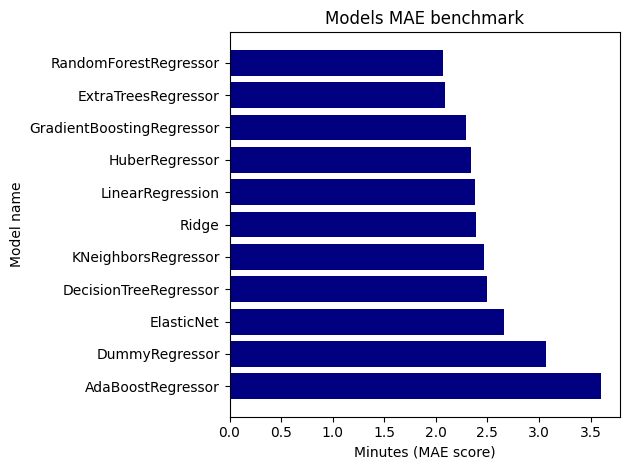

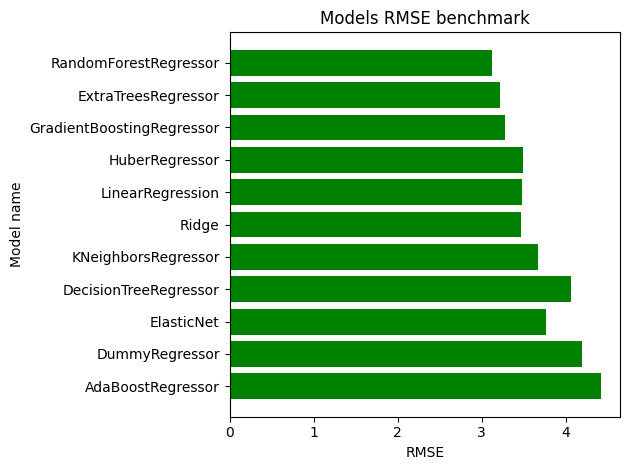

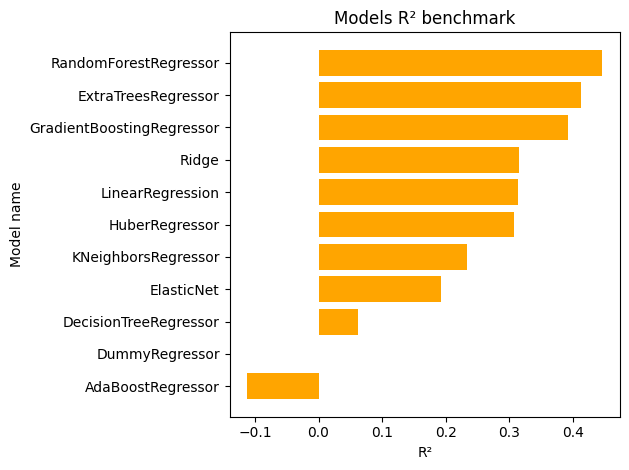

In [47]:
class Plot():
    def __init__(
        self, 
        df_plot: object,
        columns: list[str],
        title_save: str,
        title: str,
        x_label: str,
        y_label: str,
        reverse_y_axis: bool=False,
        color: str='navy'
    ) -> None:
        """Method to initialisate show bar plot."""

        self._df, self._columns, self._save_title, self._title, self._x_label, self._y_label, self._reverse_y_axis, self._color = df_plot.copy(), columns, title_save, title, x_label, y_label, reverse_y_axis, color
        
        self.fig = plt.barh(self._df[self._columns[0]], self._df[self._columns[1]], color=self._color)
        ax = plt.gca()
        
        ax.set(title=self._title, xlabel=self._x_label, ylabel=self._y_label)
        if self._reverse_y_axis:
            ax.invert_yaxis()

        plt.tight_layout()
        plt.savefig(f'./assets/{self._save_title}')
        plt.show()

    def get_plot(self) -> object:
        """Getter that return the current plot figure."""
        return self.fig

plots: list[Plot] = [
    Plot(df_plot=results_df, columns=['model', 'MAE'], title_save='Model_MAE_FIRST', title='Models MAE benchmark', x_label='Minutes (MAE score)', y_label='Model name', reverse_y_axis=True),
    Plot(df_plot=results_df, columns=['model', 'RMSE'], title_save='Model_RMSE_FIRST', title='Models RMSE benchmark', x_label='RMSE', y_label='Model name', reverse_y_axis=True, color='green'),
    Plot(df_plot=results_df.sort_values(by=['R2']), columns=['model', 'R2'], title_save='Model_R²_FIRST', title='Models R² benchmark', x_label='R²', y_label='Model name', color='orange'),
]

### **9 - Filter models to get the first 8**

Filter the 8 best models in a dictionary

In [48]:
top_8_models = {model_name: models_init[model_name] for model_name in results_df['model'].head(8).to_list()}

### **10 - Get the bests hyperparameters for each model**

Create a function that takes a list of models as a parameter, and for each of them, it retrieves its best hyperparameters, then returns a list of the models retrained with the same, normally optimal, parameters. The subtlety here is that we will measure in advance, using ParameterGrid and the number of test sets we choose, the number of training/test runs that will need to be performed to find the best hyperparameters using GridSearchCV, and depending on this number, we will either use... If I understand correctly,

In [49]:
def tune_models(models: dict[str, dict]) -> dict[str, dict]:
    """Tune hyperparameters for each model config and return fitted best estimators."""
    tuned_models = deepcopy(models)

    print('--------- Logs tuning --------')
    for name, model_data in tuned_models.items():
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model_data.get('instance'))
        ])

        param_grid = model_data.get('param_grid', {})

        if not param_grid:
            tuned_models[name]['instance'] = pipe.fit(X_train, y_train)
            continue

        n_candidates = len(ParameterGrid(param_grid))
        cv = 3
        n_fits = n_candidates * cv
        use_randomized = n_fits > 500

        print(f'{name} | {use_randomized and f"number of fits > 500 ({n_fits}), using RandomizedSearchCV" or f"number of fits <= 500 ({n_fits}), using GridSearchCV"} ')

        if use_randomized:
            search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=min(20, n_candidates), n_jobs=-1, scoring='neg_mean_absolute_error', cv=cv, refit=True, random_state=42, verbose=True)
        else:
            search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, refit=True, verbose=True)

        search.fit(X_train, y_train)
        tuned_models[name]['instance'] = search.best_estimator_

        print('------------------------------')

    return tuned_models

### **11 - Last benchmark with the best hyperparameters**

We do another benchmark, this time with our 8 models trained with the optimal hyperparameters, and we display it as a dataframe.

In [50]:
tuned_models_last = tune_models(top_8_models)
models_last_benchmark = models_benchmark(tuned_models_last)

results_df_last = pd.DataFrame(models_last_benchmark).sort_values(by=['MAE', 'RMSE', 'R2']).reset_index(drop=True)
top_5_best_model = results_df_last.head(5)
best_model = tuned_models_last[results_df_last.head(1)['model'].values[0]]['instance']

print(results_df_last)

--------- Logs tuning --------
RandomForestRegressor | number of fits > 500 (972), using RandomizedSearchCV 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
------------------------------
ExtraTreesRegressor | number of fits > 500 (972), using RandomizedSearchCV 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
------------------------------
GradientBoostingRegressor | number of fits > 500 (1458), using RandomizedSearchCV 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
------------------------------
HuberRegressor | number of fits <= 500 (96), using GridSearchCV 
Fitting 3 folds for each of 32 candidates, totalling 96 fits
------------------------------
Ridge | number of fits <= 500 (15), using GridSearchCV 
Fitting 3 folds for each of 5 candidates, totalling 15 fits
------------------------------
KNeighborsRegressor | number of fits <= 500 (72), using GridSearchCV 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
---------------------

### **12 - Show performance of each models with plots after finding best hyperparameters**

We use our Plot class to display the same metrics again, but with the new benchmark.

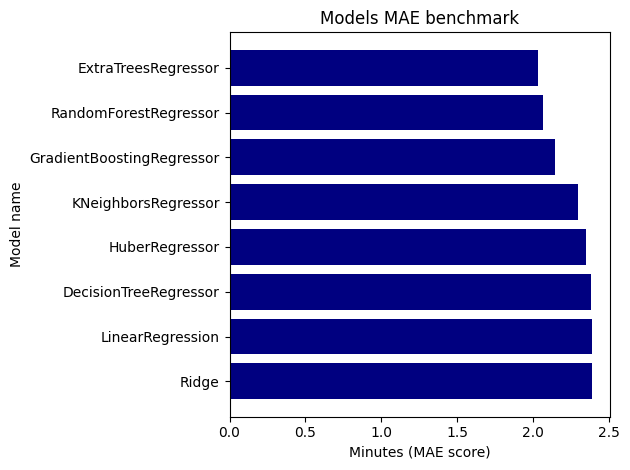

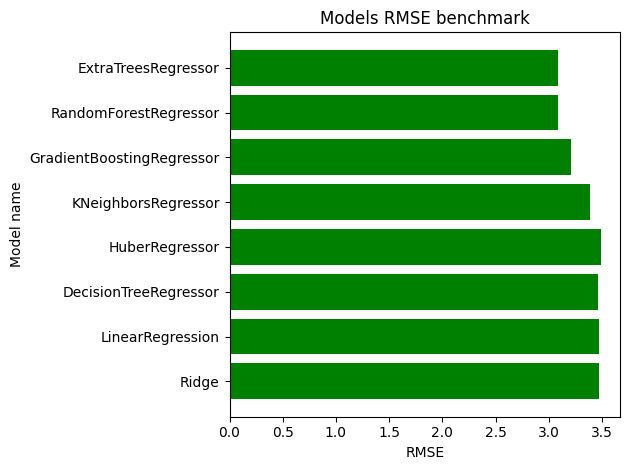

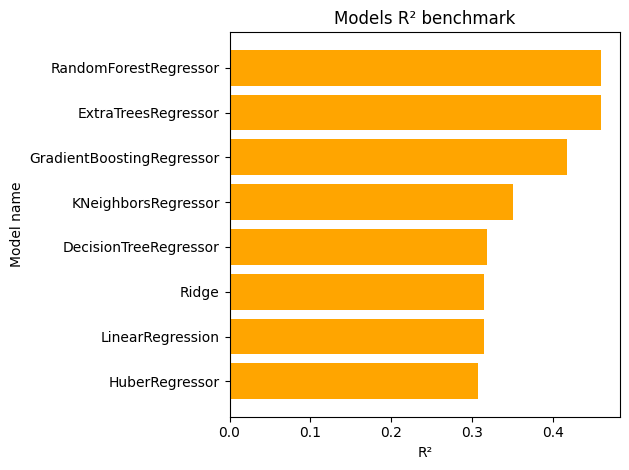

In [51]:
plots: list[Plot] = [
    Plot(df_plot=results_df_last, columns=['model', 'MAE'], title_save='Model_MAE_SEC', title='Models MAE benchmark', x_label='Minutes (MAE score)', y_label='Model name', reverse_y_axis=True),
    Plot(df_plot=results_df_last, columns=['model', 'RMSE'], title_save='Model_RMSE_SEC', title='Models RMSE benchmark', x_label='RMSE', y_label='Model name', reverse_y_axis=True, color='green'),
    Plot(df_plot=results_df_last.sort_values(by=['R2']), columns=['model', 'R2'], title_save='Model_R²_SEC', title='Models R² benchmark', x_label='R²', y_label='Model name', color='orange'),
]

### **13 - Export best model with joblib**

We can now take the model with the lowest MEA score out of the 8 best, and export it as a .joblib, so that it can be imported into the python file which will create the interactive streamlit dashboard, and thus make predictions.

In [52]:
print(f'The best model is : {results_df_last.head(1)["model"].values[0]}\n')
print(f'Final evaluation : {evaluate_regression(y_test, best_model.predict(X_test))}\n')
print('Exporting...')

export_data = {
    "model": best_model,
    "year_min": year_min,
}

joblib.dump(export_data, "model.joblib")

The best model is : ExtraTreesRegressor

Final evaluation : {'MAE': 2.0326768338592904, 'RMSE': 3.0887481892499373, 'R2': 0.4587098367223851}

Exporting...


['model.joblib']

### **14 - Model use case**

We illustrate a use case of the model by first importing it using joblib, then creating a function that takes as parameters the model, the departure and arrival stations, the average travel time on that line, the month of the year, whether the journey is national or international, and returns the model's predicted delay time in minutes. Next, to illustrate this example, I randomly select a row from the dataframe and insert its values ​​into the prediction function, then compare the prediction to reality. This provides a real-world example of its use.

In [53]:
bundle = joblib.load("model.joblib")
model = bundle["model"]
year_min = bundle["year_min"]

def predict_delay(
    model,
    depart: str,
    arrivee: str,
    duree: int | float,
    month: int,
    Year: int,
    national: bool=True,
    international: bool=False,
):
    """Return prediction of delay in minutes."""

    df_predict = pd.DataFrame([{
        "Gare de départ": depart,
        "Gare d'arrivée": arrivee,
        "Durée moyenne du trajet": duree,
        "Is_Service_National": national,
        "Is_Service_International": international,
        "month": month,
        "Year": Year,
    }])

    df_predict['month_sin'] = np.sin(2 * np.pi * (df_predict['month'] - 1) / 12)
    df_predict['month_cos'] = np.cos(2 * np.pi * (df_predict['month'] - 1) / 12)
    df_predict["route"] = df_predict["Gare de départ"] + " -> " + df_predict["Gare d'arrivée"]
    df_predict['year_idx'] = df_predict['Year'] - year_min

    return float(model.predict(df_predict)[0])

rows = df.shape[0]
random_row = df.iloc[random.randint(0, rows-1)]

prediction = predict_delay(
    model=best_model,
    depart=random_row['Gare de départ'],
    arrivee=random_row['Gare d\'arrivée'],
    duree=random_row['Durée moyenne du trajet'],
    month=random_row['month'],
    Year=random_row['Year'],
    national=random_row['Is_Service_National'],
    international=random_row['Is_Service_International']
)

reality = random_row['Retard moyen de tous les trains à l\'arrivée']

def minutes_to_min_secondes(x):
    minutes = int(x)
    seconds = int(round((x - minutes) * 60))
    if seconds == 60:
        minutes += 1
        seconds = 0
    return minutes, seconds

prediction_m, prediction_s = minutes_to_min_secondes(prediction)
reality_m, reality_s = minutes_to_min_secondes(reality)

print(f"Prediction : {prediction_m} min {prediction_s:02d} s | Reality : {reality_m} min {reality_s:02d} s")

Prediction : 6 min 48 s | Reality : 6 min 31 s
